In [43]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

In [44]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
labels = np.array(labels)

In [45]:
preds = pickle.load(open('predictions', 'rb'))
hist = pickle.load(open('train_hist', 'rb'))

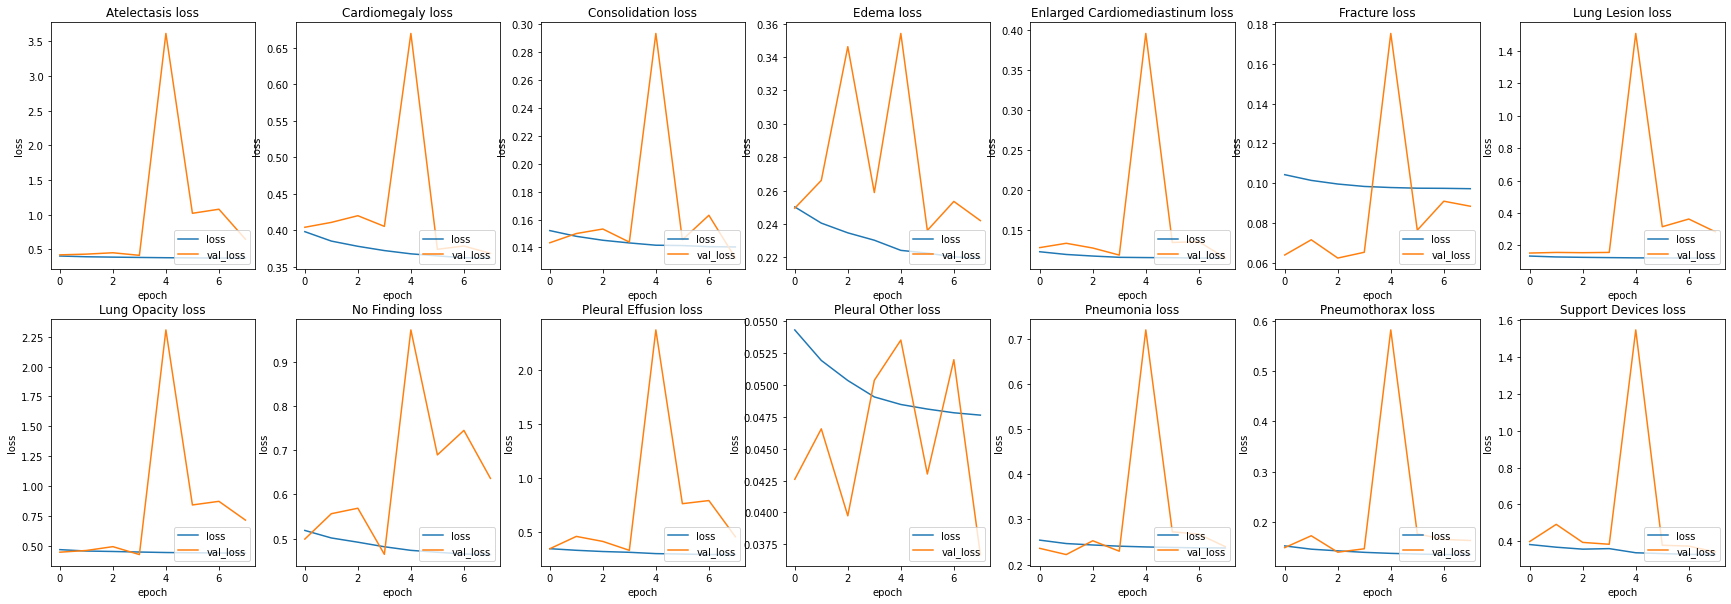

In [46]:
# Loss Plots
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
for i, lab in enumerate(labels):
    loss = hist[f'dense_{str(i+1)}_loss']
    val_loss = hist[f'val_dense_{str(i+1)}_loss']
    title = f'{lab} loss'

    if i < 7:
        x = 0
    else:
        x = 1
    
    if i < 7:
        y = i
    else:
        y = i - 7

    ax[x, y].plot(loss, label='loss')
    ax[x, y].plot(val_loss, label='val_loss')
    ax[x, y].title.set_text(title)
    ax[x, y].legend(loc=4)
    ax[x, y].set_xlabel('epoch')
    ax[x, y].set_ylabel('loss')
    
    


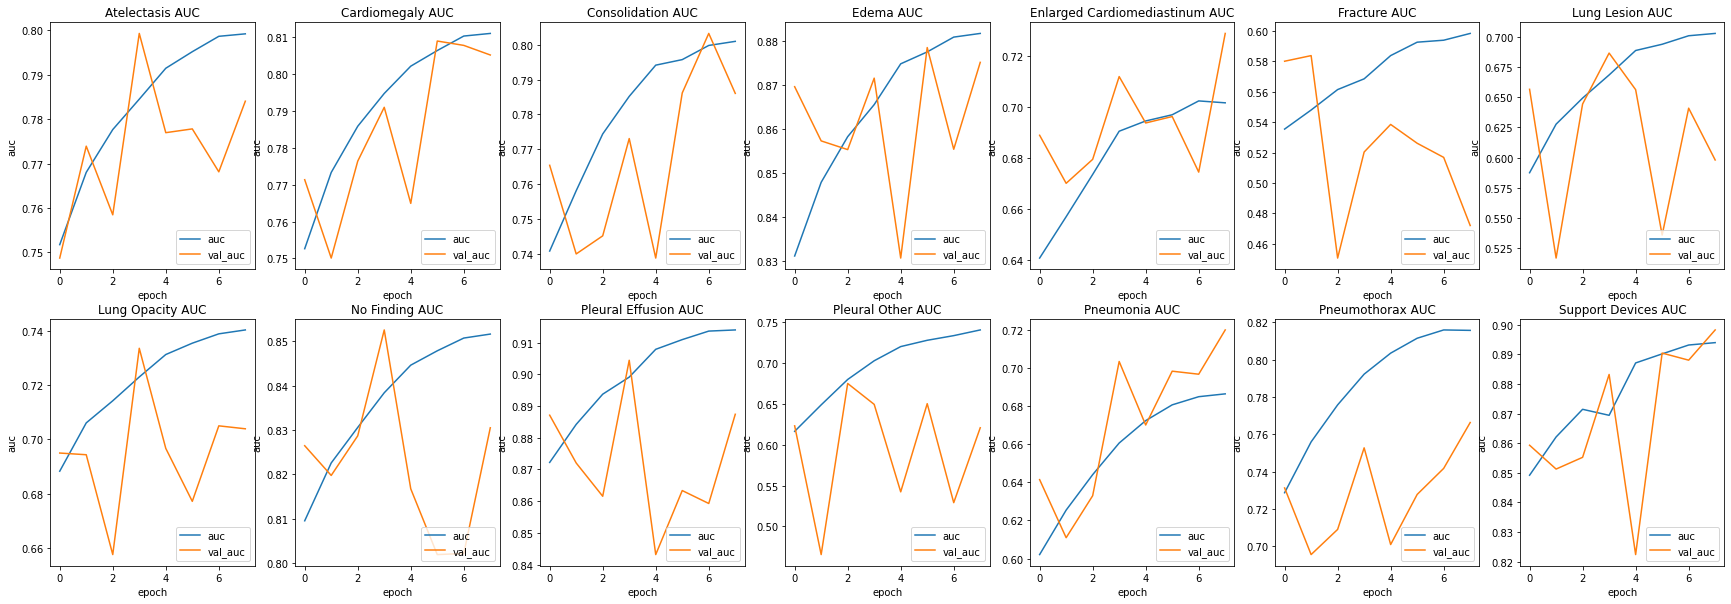

In [47]:
# Loss Plots
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
for i, lab in enumerate(labels):
    auc = hist[f'dense_{str(i+1)}_auc']
    val_auc = hist[f'val_dense_{str(i+1)}_auc']
    title = f'{lab} AUC'

    if i < 7:
        x = 0
    else:
        x = 1
    
    if i < 7:
        y = i
    else:
        y = i - 7

    ax[x, y].plot(auc, label='auc')
    ax[x, y].plot(val_auc, label='val_auc')
    ax[x, y].title.set_text(title)
    ax[x, y].legend(loc=4)
    ax[x, y].set_xlabel('epoch')
    ax[x, y].set_ylabel('auc')

In [48]:
preds = np.array(preds)

In [49]:
preds.shape

(14, 5159, 1)

In [50]:
shaped = preds.T[0]

In [51]:
shaped.shape

(5159, 14)

In [34]:
test = pd.read_csv('../../../../processed_splits/test.csv')
test = test.fillna(0)

In [35]:
results = pd.DataFrame(shaped, columns=['pred_' + x for x in labels])

In [36]:
merged = pd.concat([test, results], axis=1)

In [39]:
merged = merged.dropna()

In [40]:
merged.shape

(3403, 42)

In [41]:
fpr = {}
tpr = {}
auc = {}
for lab in labels:
    ytrue = merged[lab]
    ypred = merged['pred_'+lab]
    tfpr, ttpr, _ = roc_curve(ytrue, ypred)
    tauc = roc_auc_score(ytrue, ypred)
    fpr[lab] = tfpr
    tpr[lab] = ttpr
    auc[lab] = tauc


In [42]:
auc

{'Atelectasis': 0.5022165503750627,
 'Cardiomegaly': 0.5168730679098523,
 'Consolidation': 0.5037185677463801,
 'Edema': 0.5077434960190419,
 'Enlarged Cardiomediastinum': 0.49802651336393666,
 'Fracture': 0.5317755778323142,
 'Lung Lesion': 0.5176117162987697,
 'Lung Opacity': 0.5196430899802046,
 'No Finding': 0.5343439737352162,
 'Pleural Effusion': 0.5327370353663652,
 'Pleural Other': 0.5379574184963407,
 'Pneumonia': 0.4753730673192837,
 'Pneumothorax': 0.590389479008599,
 'Support Devices': 0.5231357025321415}

In [17]:
aps_macro = {}
aps_weighted = {}
for lab in labels:
    ytrue = merged[lab]
    ypred = merged['pred_'+lab]
    taps = average_precision_score(ytrue, ypred, average='macro')
    aps_macro[lab] = taps

for lab in labels:
    ytrue = merged[lab]
    ypred = merged['pred_'+lab]
    taps = average_precision_score(ytrue, ypred, average='weighted')
    aps_weighted[lab] = taps

In [18]:
aps_macro

{'Atelectasis': 0.36489053291378953,
 'Cardiomegaly': 0.44104599988988724,
 'Consolidation': 0.11256724536830005,
 'Edema': 0.46770387300664745,
 'Enlarged Cardiomediastinum': 0.05614225837775663,
 'Fracture': 0.041511416511539334,
 'Lung Lesion': 0.0652809594770004,
 'Lung Opacity': 0.4236957781076492,
 'No Finding': 0.48545361841628215,
 'Pleural Effusion': 0.7280664614512098,
 'Pleural Other': 0.05598251106849145,
 'Pneumonia': 0.1541310631935423,
 'Pneumothorax': 0.08127306569651034,
 'Support Devices': 0.7109495159541004}

In [24]:
def calc_auprc(df, labels):

    fpr = {}
    tpr = {}
    auc = {}

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        opre, orec, _ = precision_recall_curve(df[lab], df['pred_'+lab])
        avg_pre = average_precision_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(orec, opre, label=f'Average Precision={round(avg_pre, 2)}')
        min = opre.min()
        ax[x, y].fill_between(orec,min,opre,alpha=0.5)
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('True Positive Rate (Recall)')
        ax[x, y].set_ylabel('Precision')

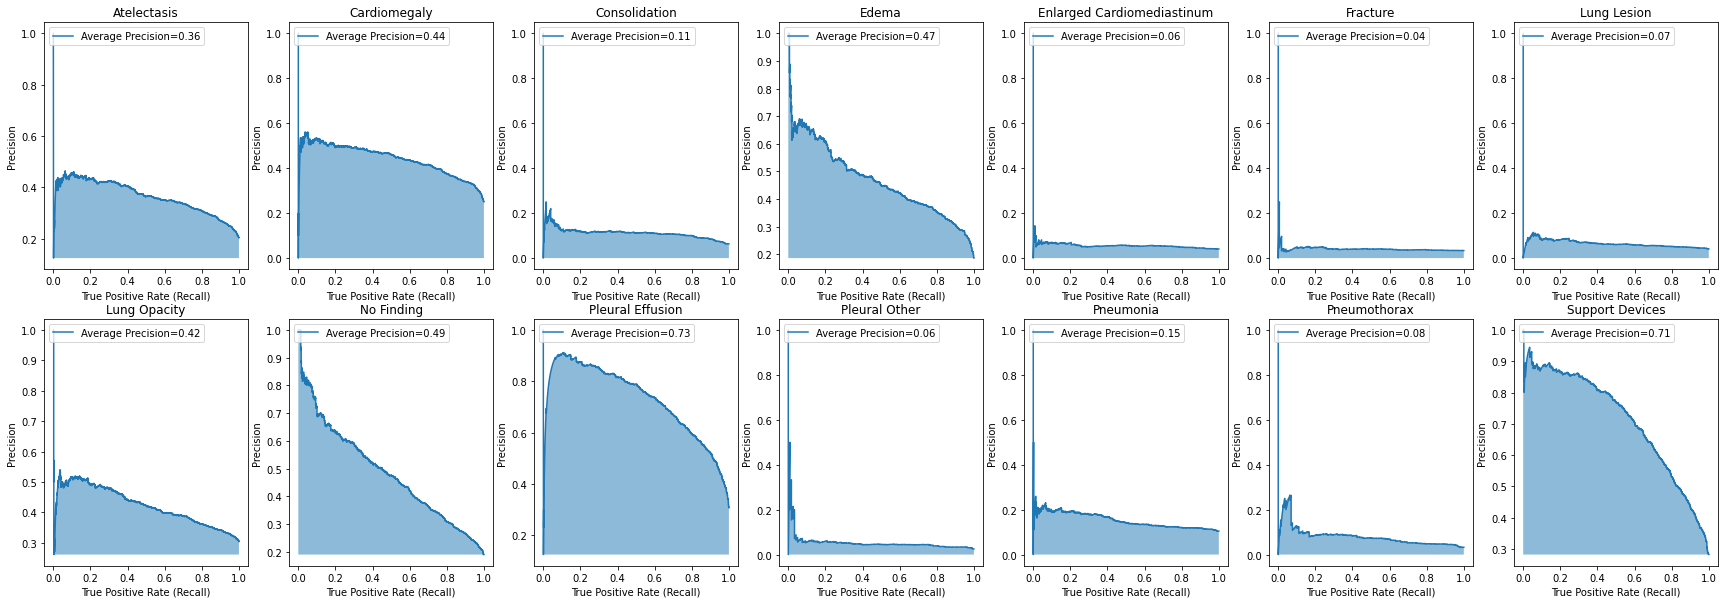

In [25]:
calc_auprc(merged,labels)

In [30]:
def calc_roc(df, labels):

    fpr = {}
    tpr = {}
    auc = {}

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)}', color='red')
        min = otpr.min()
        ax[x, y].fill_between(otpr,min,ofpr,alpha=0.5, color='red')
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('TPR')
        ax[x, y].set_ylabel('FPR')

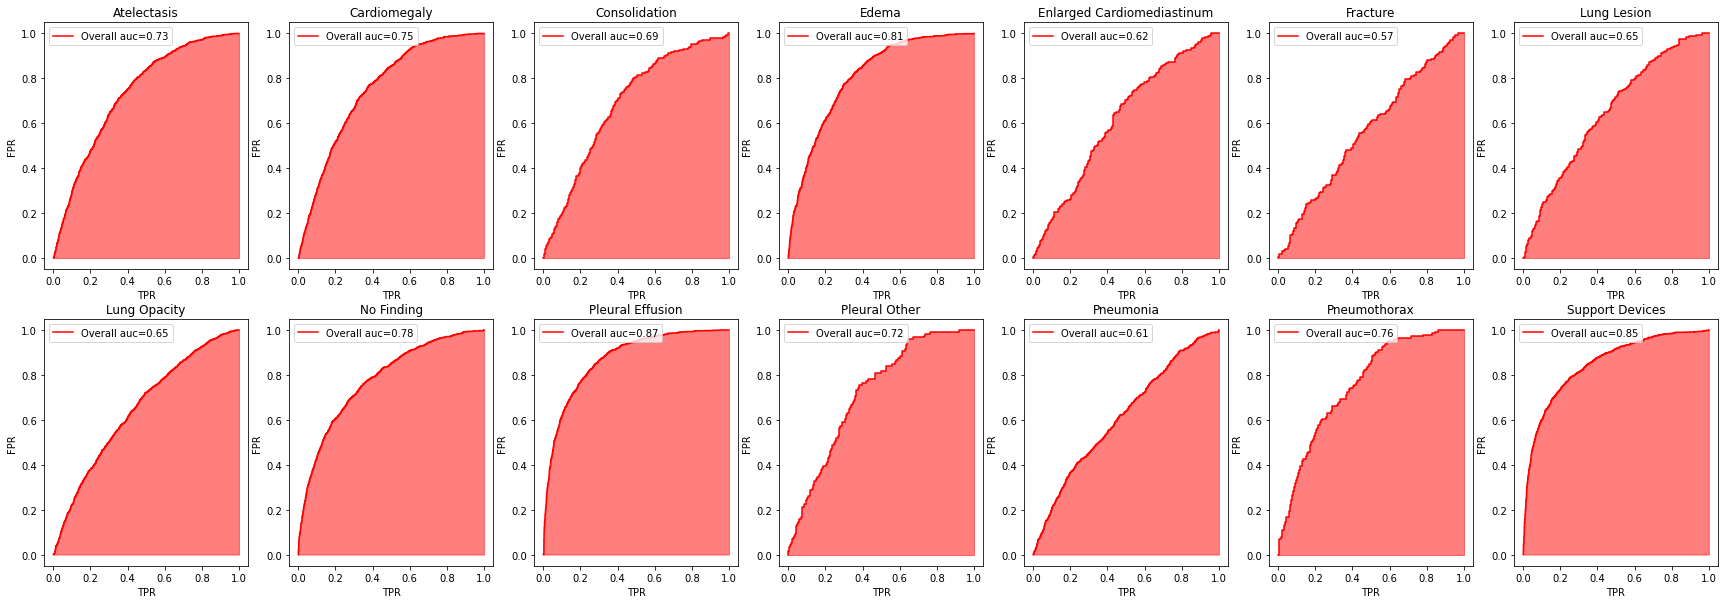

In [31]:
calc_roc(merged, labels)

In [16]:
merged.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,pred_Enlarged Cardiomediastinum,pred_Fracture,pred_Lung Lesion,pred_Lung Opacity,pred_No Finding,pred_Pleural Effusion,pred_Pleural Other,pred_Pneumonia,pred_Pneumothorax,pred_Support Devices
0,10032725,50331901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028591,0.017011,0.010158,0.117863,0.514910,0.024461,0.000972,0.033867,0.054003,0.674240
1,10032725,55504914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024768,0.015360,0.009065,0.067352,0.641565,0.009994,0.000774,0.021268,0.051336,0.690007
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.014533,0.025803,0.029284,0.181185,0.421983,0.050918,0.005211,0.072171,0.019981,0.048930
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023567,0.028461,0.029168,0.158798,0.422949,0.034958,0.006189,0.059293,0.029504,0.123027
4,10046166,51738740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018360,0.026041,0.029416,0.089340,0.603777,0.015223,0.006175,0.039030,0.016694,0.084055


In [1]:
results.shape

NameError: name 'results' is not defined

In [18]:
for lab in labels:
    print(merged[lab].value_counts())

0.0    4125
1.0    1034
Name: Atelectasis, dtype: int64
0.0    3901
1.0    1258
Name: Cardiomegaly, dtype: int64
0.0    4833
1.0     326
Name: Consolidation, dtype: int64
0.0    4200
1.0     959
Name: Edema, dtype: int64
0.0    4959
1.0     200
Name: Enlarged Cardiomediastinum, dtype: int64
0.0    4992
1.0     167
Name: Fracture, dtype: int64
0.0    4957
1.0     202
Name: Lung Lesion, dtype: int64
0.0    3598
1.0    1561
Name: Lung Opacity, dtype: int64
0.0    4175
1.0     984
Name: No Finding, dtype: int64
0.0    3617
1.0    1542
Name: Pleural Effusion, dtype: int64
0.0    5040
1.0     119
Name: Pleural Other, dtype: int64
0.0    4620
1.0     539
Name: Pneumonia, dtype: int64
0.0    5015
1.0     144
Name: Pneumothorax, dtype: int64
0.0    3702
1.0    1457
Name: Support Devices, dtype: int64


In [17]:
merged.to_csv('results.csv', index=False)